In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv')
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


In [4]:
#Previous value 48 is 24 hours/1 day, 2 observations are recorded hourly, each at 30 minute.
data['MA48'] = data['value'].rolling(48).mean()
data['MA336'] = data['value'].rolling(336).mean()

In [36]:
# data['timestamp'].loc[::500]

(array([16429., 16433., 16436., 16440., 16444., 16448.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

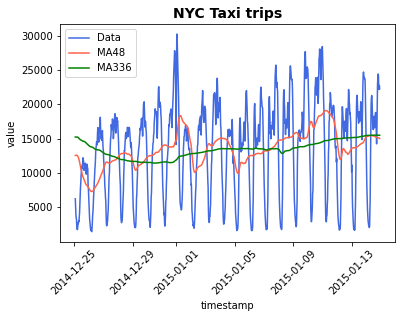

In [34]:
fig = plt.figure()

ax = sns.lineplot(x = data['timestamp'][8500:9500], y = data['value'], label="Data", color='royalblue')
ax = sns.lineplot(x = data['timestamp'][8500:9500], y = data['MA48'], label="MA48", color='tomato')
ax = sns.lineplot(x = data['timestamp'][8500:9500], y = data['MA336'], label="MA336", color='green')
ax.set_title('NYC Taxi trips', size = 14, fontweight='bold')
# plt.ylabel('Close Price (INR)',fontsize=18)
plt.xticks(rotation=45)

In [37]:
# drop moving-average columns
data.drop(['MA48', 'MA336'], axis=1, inplace=True)

# set timestamp to index
data.set_index('timestamp', drop=True, inplace=True)



In [39]:
# resample timeseries to hourly 
data = data.resample('H').sum()

# creature features from date
data['day'] = [i.day for i in data.index]
data['day_name'] = [i.day_name() for i in data.index]
data['day_of_year'] = [i.dayofyear for i in data.index]
data['week_of_year'] = [i.weekofyear for i in data.index]
data['hour'] = [i.hour for i in data.index]
data['is_weekday'] = [i.isoweekday() for i in data.index]
data.head()

,value,day,day_name,day_of_year,week_of_year,hour,is_weekday
timestamp,,,,,,,
2014-07-01 00:00:00,18971,1,Tuesday,182,27,0,2
2014-07-01 01:00:00,10866,1,Tuesday,182,27,1,2
2014-07-01 02:00:00,6693,1,Tuesday,182,27,2,2
2014-07-01 03:00:00,4433,1,Tuesday,182,27,3,2
2014-07-01 04:00:00,4379,1,Tuesday,182,27,4,2


In [40]:
from pycaret.anomaly import *
s = setup(data, session_id = 123)

,Description,Value
0,session_id,123
1,Original Data,"(5160, 7)"
2,Missing Values,False
3,Numeric Features,5
4,Categorical Features,2
5,Ordinal Features,False
6,High Cardinality Features,False
7,High Cardinality Method,None
8,Transformed Data,"(5160, 19)"
9,CPU Jobs,-1


In [41]:
# check list of available models
models()

,Name,Reference
ID,,
abod,Angle-base Outlier Detection,pyod.models.abod.ABOD
cluster,Clustering-Based Local Outlier,pyod.models.cblof.CBLOF
cof,Connectivity-Based Local Outlier,pyod.models.cof.COF
iforest,Isolation Forest,pyod.models.iforest.IForest
histogram,Histogram-based Outlier Detection,pyod.models.hbos.HBOS
knn,K-Nearest Neighbors Detector,pyod.models.knn.KNN
lof,Local Outlier Factor,pyod.models.lof.LOF
svm,One-class SVM detector,pyod.models.ocsvm.OCSVM
pca,Principal Component Analysis,pyod.models.pca.PCA


In [87]:
# train model
iforest = create_model('iforest', fraction = 0.1)
iforest_results = assign_model(iforest)
iforest_results

,value,day,day_name,day_of_year,week_of_year,hour,is_weekday,Anomaly,Anomaly_Score
timestamp,,,,,,,,,
2014-07-01 00:00:00,18971,1,Tuesday,182,27,0,2,0,-0.015450
2014-07-01 01:00:00,10866,1,Tuesday,182,27,1,2,0,-0.006367
2014-07-01 02:00:00,6693,1,Tuesday,182,27,2,2,0,-0.010988
2014-07-01 03:00:00,4433,1,Tuesday,182,27,3,2,0,-0.017091
2014-07-01 04:00:00,4379,1,Tuesday,182,27,4,2,0,-0.017006
...,...,...,...,...,...,...,...,...,...
2015-01-31 19:00:00,56577,31,Saturday,31,5,19,6,1,0.021509
2015-01-31 20:00:00,48276,31,Saturday,31,5,20,6,1,0.018262
2015-01-31 21:00:00,48389,31,Saturday,31,5,21,6,1,0.019220


In [86]:
# check anomalies
iforest_results[iforest_results['Anomaly'] == 1]

,value,day,day_name,day_of_year,week_of_year,hour,is_weekday,Anomaly,Anomaly_Score
timestamp,,,,,,,,,
2014-07-13 00:00:00,50825,13,Sunday,194,28,0,7,1,0.002663
2014-07-27 00:00:00,50407,27,Sunday,208,30,0,7,1,0.009264
2014-08-03 00:00:00,48081,3,Sunday,215,31,0,7,1,0.003045
2014-09-28 00:00:00,53589,28,Sunday,271,39,0,7,1,0.004440
2014-10-05 00:00:00,48472,5,Sunday,278,40,0,7,1,0.000325
...,...,...,...,...,...,...,...,...,...
2015-01-31 19:00:00,56577,31,Saturday,31,5,19,6,1,0.021509
2015-01-31 20:00:00,48276,31,Saturday,31,5,20,6,1,0.018262
2015-01-31 21:00:00,48389,31,Saturday,31,5,21,6,1,0.019220


,date,values
0,2014-07-13,50825
1,2014-07-27,50407
2,2014-08-03,48081
3,2014-09-28,53589
4,2014-10-05,48472


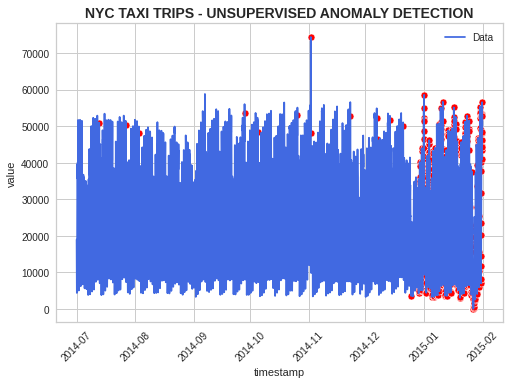

In [101]:
# plot value on y-axis and date on x-axis

fig = plt.figure()

ax = sns.lineplot(x = iforest_results.index, y = iforest_results['value'], label="Data", color='royalblue')
# ax = sns.lineplot(x = data['timestamp'][8500:9500], y = data['MA48'], label="MA48", color='tomato')
# ax = sns.lineplot(x = data['timestamp'][8500:9500], y = data['MA336'], label="MA336", color='green')
ax.set_title('NYC TAXI TRIPS - UNSUPERVISED ANOMALY DETECTION', size = 14, fontweight='bold')
# plt.ylabel('Close Price (INR)',fontsize=18)
plt.xticks(rotation=45)

# fig = px.line(iforest_results, x=iforest_results.index, y="value", title='NYC TAXI TRIPS - UNSUPERVISED ANOMALY DETECTION', template = 'plotly_dark')

# create list of outlier_dates
outlier_dates = iforest_results[iforest_results['Anomaly'] == 1].index



# obtain y value of anomalies to plot
y_values = [iforest_results.loc[i]['value'] for i in outlier_dates]

anomalies_dict = {'date':outlier_dates, 'values':y_values}

anomalies_df = pd.DataFrame(anomalies_dict)
anomalies_df.set_index('date')

ax = sns.scatterplot(data=anomalies_df, x="date", y="values", color="red")
# fig.add_trace(go.Scatter(x=outlier_dates, y=y_values, mode = 'markers', 
#                 name = 'Anomaly', 
#                 marker=dict(color='red',size=10)))
        
# fig.show()

anomalies_df.head()